In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex

sns.set_style('whitegrid')

from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import f1_score



In [2]:


df_loan = pd.read_csv("data/loan.csv")
df_loan.head()


<ipython-input-2-bffc2a3e727a>:1: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df_loan = pd.read_csv("data/loan.csv")


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_loan.shape

(887379, 74)

In [4]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           887379 non-null  int64  
 1   member_id                    887379 non-null  int64  
 2   loan_amnt                    887379 non-null  float64
 3   funded_amnt                  887379 non-null  float64
 4   funded_amnt_inv              887379 non-null  float64
 5   term                         887379 non-null  object 
 6   int_rate                     887379 non-null  float64
 7   installment                  887379 non-null  float64
 8   grade                        887379 non-null  object 
 9   sub_grade                    887379 non-null  object 
 10  emp_title                    835917 non-null  object 
 11  emp_length                   842554 non-null  object 
 12  home_ownership               887379 non-null  object 
 13 

In [5]:
#df_loan.drop(df_loan.columns.difference(['loan_amnt','term','int_rate','installment','grade','emp_length','home_ownership',
#                                         'annual_inc','verification_status','loan_status','purpose',]), 1, inplace=True)

df_loan=df_loan[['loan_amnt','term','int_rate','installment','grade','emp_length','home_ownership','annual_inc','verification_status','loan_status','purpose']]

In [6]:
df_loan.isnull().sum()

loan_amnt                  0
term                       0
int_rate                   0
installment                0
grade                      0
emp_length             44825
home_ownership             0
annual_inc                 4
verification_status        0
loan_status                0
purpose                    0
dtype: int64

In [7]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   loan_amnt            887379 non-null  float64
 1   term                 887379 non-null  object 
 2   int_rate             887379 non-null  float64
 3   installment          887379 non-null  float64
 4   grade                887379 non-null  object 
 5   emp_length           842554 non-null  object 
 6   home_ownership       887379 non-null  object 
 7   annual_inc           887375 non-null  float64
 8   verification_status  887379 non-null  object 
 9   loan_status          887379 non-null  object 
 10  purpose              887379 non-null  object 
dtypes: float64(4), object(7)
memory usage: 74.5+ MB


In [8]:
df_loan.annual_inc = df_loan.annual_inc.fillna(0)
df_loan.isnull().sum()

loan_amnt                  0
term                       0
int_rate                   0
installment                0
grade                      0
emp_length             44825
home_ownership             0
annual_inc                 0
verification_status        0
loan_status                0
purpose                    0
dtype: int64

In this column, the value 0 will be filled with the correct conditions: 'Fully Paid', 'Does not meet the credit policy. Status:Fully Paid', 'Current'
Meanwhile, the value of 1 will be filled with incorrect conditions: 'Late (31-120 days)', 'Late (16-30 days)', 'In Grace Period', 'Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off'

In [9]:
# binary classification
label_categories = [
    (0, ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid', 'Current']),
    (1, ['Late (31-120 days)', 'Late (16-30 days)', 'In Grace Period', 
         'Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off'])
]

# function to apply the transformation
def classify_label(text):
    for category, matches in label_categories:
        if any(match in text for match in matches):
            return category
    return None

df_loan.loc[:, 'label'] = df_loan['loan_status'].apply(classify_label)
df_loan = df_loan.drop('loan_status', axis=1)


In [10]:
# label several label with specific grading system.
def SC_LabelEncoder1(text):
    if text == "E":
        return 1
    elif text == "D":
        return 2
    elif text == "C":
        return 3
    elif text == "B":
        return 4
    elif text == "A":
        return 5
    else:
        return 0
    
    
def SC_LabelEncoder2(text):
    if text == "< 1 year":
        return 1
    elif text == "1 year":
        return 2
    elif text == "2 years":
        return 3
    elif text == "3 years":
        return 4
    elif text == "4 years":
        return 5
    elif text == "5 years":
        return 6
    elif text == "6 years":
        return 7
    elif text == "7 years":
        return 8
    elif text == "8 years":
        return 9
    elif text == "9 years":
        return 10
    elif text == "10 years":
        return 11
    elif text == "10+ years":
        return 12
    else:
        return 0

def SC_LabelEncoder3(text):
    if text == "RENT":
        return 1
    elif text == "MORTGAGE":
        return 2
    elif text == "OWN":
        return 3
    else:
        return 0
    
df_loan["grade"] = df_loan["grade"].apply(SC_LabelEncoder1)
df_loan["emp_length"] = df_loan["emp_length"].apply(SC_LabelEncoder2)
df_loan["home_ownership"] = df_loan["home_ownership"].apply(SC_LabelEncoder3)


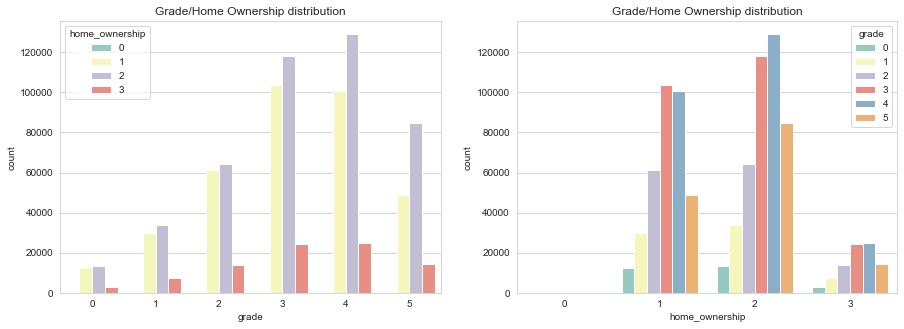

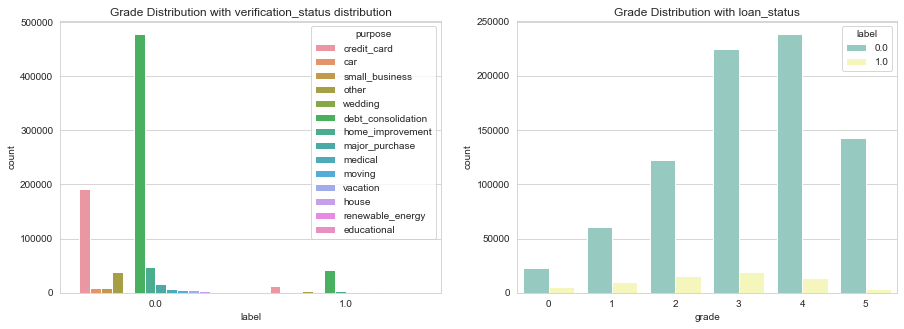

In [12]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(data=df_loan, x='grade', hue="home_ownership", ax=ax[0]).set_title("Grade/Home Ownership distribution");
sns.countplot(data=df_loan, x='home_ownership', hue='grade', ax=ax[1]).set_title("Grade/Home Ownership distribution");

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(data=df_loan, x='label', hue='purpose', ax=ax[0]).set_title("Grade Distribution with verification_status distribution");
sns.countplot(data=df_loan, x='grade', hue='label', ax=ax[1]).set_title("Grade Distribution with loan_status");


Text(0.5, 1.0, 'Loan amounts grouped by purpose')

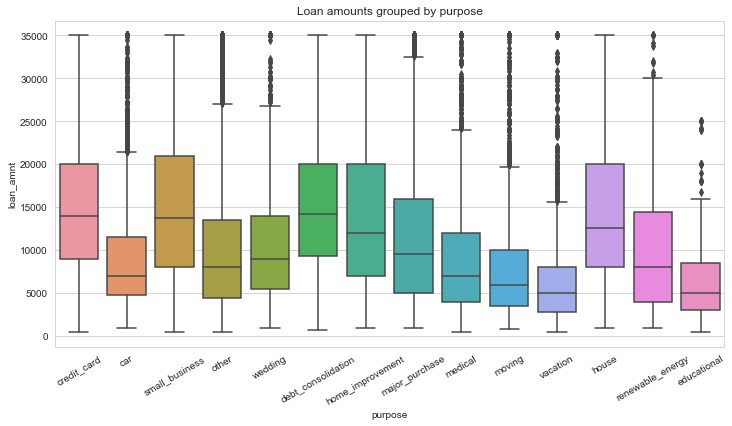

In [13]:
plt.figure(figsize=(12,6))
sns.boxplot(x='purpose', y='loan_amnt', data=df_loan)
plt.xticks(rotation=30)
plt.title('Loan amounts grouped by purpose')


Based on above loan amounts grouped by purpose, here are some findings:
1. House loan and credit card loan amount are very similar in range. This house loan is likely for renovations etc but not home mortgage 
2. Educational loan doesnt exceed 25K even with outliers
3. car loans, vacation, moving and medical have many outliers

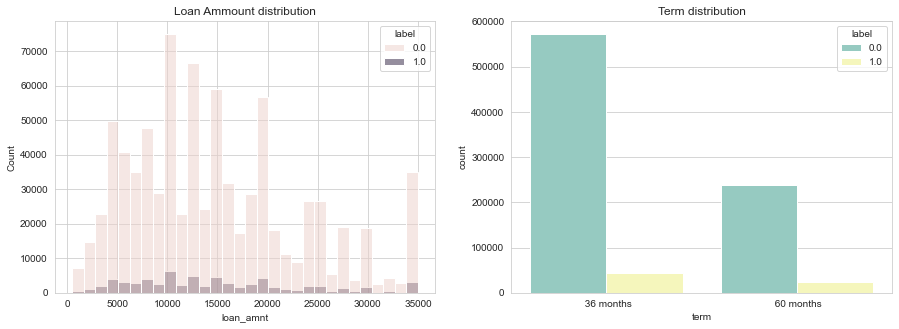

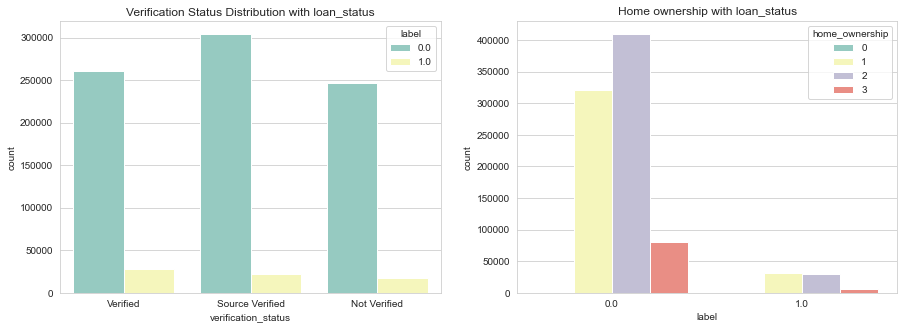

In [14]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(df_loan, x='loan_amnt',hue="label", bins=30, ax=ax[0]).set_title("Loan Ammount distribution");
sns.countplot(data=df_loan, x='term', hue="label", ax=ax[1]).set_title("Term distribution");

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(data=df_loan, hue='home_ownership', x='label', ax=ax[1]).set_title("Home ownership with loan_status");
sns.countplot(data=df_loan, x='verification_status', hue='label', ax=ax[0]).set_title("Verification Status Distribution with loan_status");


Analysis

<ipython-input-15-6ad682432b0f>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr,linewidths=.5, annot=True, cmap="YlGnBu",mask=np.triu(np.ones_like(corr, dtype=np.bool)))\


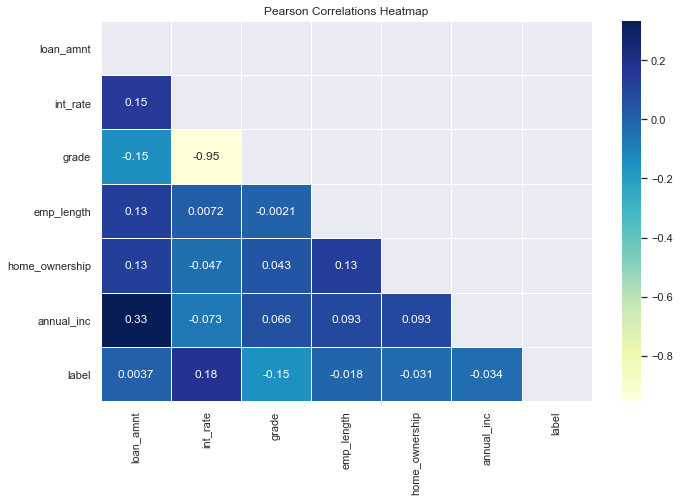

In [15]:
corr = df_loan[['loan_amnt', 'int_rate', 'grade', 'emp_length', 'home_ownership', 'annual_inc','purpose','label']].corr()
sns.set(rc={'figure.figsize':(11,7)})
sns.heatmap(corr,linewidths=.5, annot=True, cmap="YlGnBu",mask=np.triu(np.ones_like(corr, dtype=np.bool)))\
    .set_title("Pearson Correlations Heatmap");

In [ ]:
#Pre processing data for discrete columns

In [18]:
df_loan.term

0          36 months
1          60 months
2          36 months
3          36 months
4          60 months
             ...    
887374     36 months
887375     36 months
887376     60 months
887377     60 months
887378     36 months
Name: term, Length: 887379, dtype: object

In [19]:
# use LabelEncoder() to encode another category column:
for col in ["verification_status", "purpose","term"]:
    le = LabelEncoder()
    le.fit(df_loan[col])
    df_loan[col] = le.transform(df_loan[col])
df_loan.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,label
0,5000.0,0,10.65,162.87,4,12,1,24000.0,2,1,0.0
1,2500.0,1,15.27,59.83,3,1,1,30000.0,1,0,1.0
2,2400.0,0,15.96,84.33,3,12,1,12252.0,0,11,0.0
3,10000.0,0,13.49,339.31,3,12,1,49200.0,1,9,0.0
4,3000.0,1,12.69,67.79,4,2,1,80000.0,1,9,0.0


In [20]:
df_loan.isnull().sum()

loan_amnt                 0
term                      0
int_rate                  0
installment               0
grade                     0
emp_length                0
home_ownership            0
annual_inc                0
verification_status       0
purpose                   0
label                  8460
dtype: int64

In [21]:
df_loan.label = df_loan.label.fillna(1)

In [22]:
df_loan

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,label
0,5000.0,0,10.65,162.87,4,12,1,24000.0,2,1,0.0
1,2500.0,1,15.27,59.83,3,1,1,30000.0,1,0,1.0
2,2400.0,0,15.96,84.33,3,12,1,12252.0,0,11,0.0
3,10000.0,0,13.49,339.31,3,12,1,49200.0,1,9,0.0
4,3000.0,1,12.69,67.79,4,2,1,80000.0,1,9,0.0
...,...,...,...,...,...,...,...,...,...,...,...
887374,10000.0,0,11.99,332.10,4,9,1,31000.0,2,2,0.0
887375,24000.0,0,11.99,797.03,4,12,2,79000.0,2,4,0.0
887376,13000.0,1,15.99,316.07,2,6,1,35000.0,2,2,0.0
887377,12000.0,1,19.99,317.86,1,2,1,64400.0,1,2,0.0


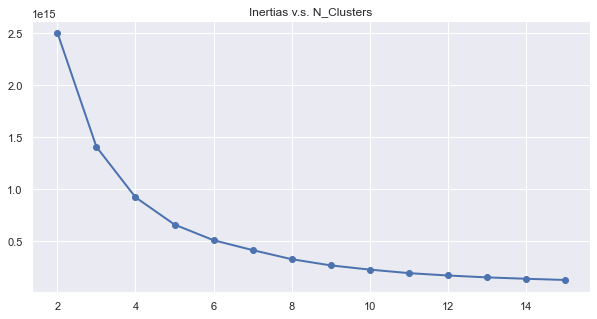

In [23]:
#Clustering
inertias = []

for i in range(2,16):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(df_loan)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.title('Inertias v.s. N_Clusters')
plt.plot(np.arange(2,16),inertias, marker='o', lw=2);


In [24]:
km = KMeans(n_clusters=4, random_state=0).fit(df_loan)
clusters = km.fit_predict(df_loan)
df_clustered = df_loan[['loan_amnt', 'int_rate', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'purpose']]
df_clustered["Cluster"] = clusters
sns.pairplot(df_clustered[['loan_amnt', 'int_rate', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'purpose'
                           , "Cluster"]], hue="Cluster");

<ipython-input-24-de72c6c44e69>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustered["Cluster"] = clusters


In [ ]:
#Predicting risk using KNN model

X, y = df_loan.drop("label", axis=1), df_loan["label"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=0)
max_score = 0
max_k = 0
for k in range(1, 100):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train,y_train)
    score = f1_score(y_test, neigh.predict(X_test),average='micro')
    if score > max_score:
        max_k = k
        max_score = score

In [ ]:
#Try with Random Forest classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree


forest = RandomForestClassifier(oob_score=True, random_state=42).fit(X_train, y_train)
score = forest.oob_score_
print(score)
acc = forest.score(X_test, y_test)


Try with different number of trees

In [ ]:
n_trees = [1, 10, 100, 500, 1000, 2000]

oob_scores = []
acc=[]
for i in n_trees:
    forest = RandomForestClassifier(random_state=42, oob_score=True, n_estimators=i).fit(X, y)
    oob_scores.append(forest.oob_score_)
    acc.append(forest.score(X_test, y_test))

print(oob_scores)

In [ ]:
print(acc)

In [ ]:
depths = [1, 2, 3, 4, 5, None]
depth_oobs = []
acc=[]

    

depth_oobs = []
for d in depths:
    forest = RandomForestClassifier(random_state=42, oob_score=True, n_estimators=200,
                                   max_depth = d).fit(X, y)
    depth_oobs.append(forest.oob_score_)
    acc.append(forest.score(X_test, y_test))



print(depth_oobs)

In [ ]:
print(acc)

Results and Summary

Since the KNN (K-Nearest Neighbors) Classification takes a lot of time and memory to predict, it is possible to use other ML models such as SVC, DecisionTree, RandomForest, and GaussianNaiveBayes.

However, in this notebook, We use KNN Model Only, and it is done and has got a good accuracy = 91.4%

Also compared KNN with random forest classifier


References:

1. https://www.kaggle.com/datasets/ranadeep/credit-risk-dataset?resource=download    
2. https://www.kaggle.com/code/ardhikamalhaq/credit-risk-analysis-using-knn-model 